# How is the use of different means of transportation influenced by meteorological conditions?
### An investigation using data for the city of Paris

Question: is the choice of means of transportation (bicycle, motorised 2-wheeler, passenger car) influenced by meteorological conditions? Do people bike only on warm sunny days? Do they switch from their motorcycle to their car when it is raining? 

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

First we read in available meteorological data for the year 2023 in Paris. We will focus on temperature, precipitation and wind speed. Here and in the following we keep only week days, since traffic patterns are different on the weekend, but this has nothing to do with meteorological conditions.

In [2]:
def read_meteo(path):
    
    meteo_df = pd.read_csv(path, sep=';', usecols=['numer_sta', 'date', 't', 'rr3', 'ff'])
    
    #keep only station number 7149, corresponding to Orly Airport near Paris
    meteo_df.drop(meteo_df[meteo_df.numer_sta!=7149].index, inplace=True) 
    meteo_df.drop('numer_sta', axis=1, inplace=True)
    meteo_df.reset_index(inplace=True, drop=True)
    
    # convert to numerical data types
    meteo_df['t'] = pd.to_numeric(meteo_df['t'], errors='coerce')        
    meteo_df['ff'] = pd.to_numeric(meteo_df['ff'], errors='coerce')
    meteo_df['rr3'] = pd.to_numeric(meteo_df['rr3'], errors='coerce')
    meteo_df['date'] = pd.to_datetime(meteo_df['date'], format='%Y%m%d%H%M%S')
    
    # get rid of negativ values for precipitation (don't know why they appear)
    meteo_df['rr3'] = np.clip(meteo_df['rr3'], 0, None)
    
    # convert from Kelvin to °C
    meteo_df['t']=meteo_df['t']-273.15
    
    # write date and time to seperate columns
    meteo_df['time'] = meteo_df['date'].dt.time
    meteo_df['weekday'] = meteo_df['date'].dt.weekday
    meteo_df['date'] = meteo_df['date'].dt.date
    
    # keep only weekdays
    meteo_df.drop(meteo_df[meteo_df.weekday==6].index, inplace=True)
    meteo_df.drop(meteo_df[meteo_df.weekday==5].index, inplace=True)
    meteo_df.reset_index(inplace=True, drop=True)
    
    meteo_df = meteo_df[['date', 'time', 'ff', 't', 'rr3']] #reorder columns
    
    meteo_df.rename(mapper={'ff': 'windspeed in m/s', 't':'temperature in °C', 'rr3':'precipitation over last 3 h in mm'}, axis=1, inplace=True)
    
    return meteo_df

In [3]:
#since we want only one value per day, calculate the means
def calc_meteo_means(meteo_df):
    
    meteo_dict = {}
    
    for group, frame in meteo_df.groupby('date'):
        day_dict = {}
        day_dict['windspeed in m/s'] = np.round(np.average(frame['windspeed in m/s']),2)
        day_dict['temperature in °C'] = np.round(np.average(frame['temperature in °C']),1)
        day_dict['precipitation over last 3 h in mm'] = np.round(np.average(frame['precipitation over last 3 h in mm']),2)
        meteo_dict[group] = day_dict
    
    return pd.DataFrame.from_dict(meteo_dict, orient='index')

In [4]:
def read_all_meteo(folder):
    
    all_meteo_df = pd.DataFrame()
    
    for filename in os.listdir(folder):
        
        f = os.path.join(folder, filename)
        
        if os.path.isfile(f):
            print(filename)
            df1 = read_meteo(f)
            df2 = calc_meteo_means(df1)
            
            all_meteo_df = pd.concat([all_meteo_df, df2])
            
            all_meteo_df.index.set_names('date', inplace=True)
    
    return all_meteo_df.sort_index()

In [5]:
all_meteo_df = read_all_meteo('meteo')

synop.202308.csv
synop.202304.csv
synop.202302.csv
synop.202311.csv
synop.202306.csv
synop.202309.csv
synop.202301.csv
synop.202310.csv
synop.202305.csv
synop.202303.csv
synop.202312.csv
synop.202307.csv


In [6]:
all_meteo_df

,windspeed in m/s,temperature in °C,precipitation over last 3 h in mm
date,,,
2023-01-02,4.12,10.5,0.72
2023-01-03,3.96,7.1,0.08
2023-01-04,6.56,11.2,0.20
2023-01-05,4.08,12.2,0.08
2023-01-06,4.60,11.2,0.00
...,...,...,...
2023-12-11,3.66,11.0,0.00
2023-12-12,3.79,11.4,0.55
2023-12-13,3.85,8.7,0.55


Now we are also reading in data coming from traffic counters in Paris:

In [7]:
def read_transport(path):
    
    transport_df = pd.read_csv(path, sep=';', usecols=['Date et heure de comptage', 'Mode déplacement', 'Nombre de véhicules'])
    
    transport_df.rename(mapper={'Date et heure de comptage': 'date', 'Mode déplacement':'means of transportation', 'Nombre de véhicules':'count'}, axis=1, inplace=True)
    
    # convert to numerical data types
    transport_df['date'] = pd.to_datetime(transport_df['date'], utc=True) # it is not UTC, but it won't work with utc=False, and since we're only looking at one time zone it does not matter
    
    # write date and time to seperate columns
    transport_df['year'] = transport_df['date'].dt.year
    transport_df['time'] = transport_df['date'].dt.time
    transport_df['weekday'] = transport_df['date'].dt.weekday
    transport_df['date'] = transport_df['date'].dt.date
    
    # keep only year 2023
    transport_df.drop(transport_df[transport_df.year!=2023].index, inplace=True)
    # keep only weekdays
    transport_df.drop(transport_df[transport_df.weekday==6].index, inplace=True)
    transport_df.drop(transport_df[transport_df.weekday==5].index, inplace=True)
    transport_df.reset_index(inplace=True, drop=True)
    
    transport_df = transport_df[['date', 'time', 'means of transportation', 'count']] # reorder columns
    
    # translate French labels to English
    transport_df.replace(to_replace = "Trottinettes + vélos", value = "scooters and bicycles", inplace=True)
    transport_df.replace(to_replace = "Véhicules légers < 3,5t", value = "light vehicles", inplace=True)
    transport_df.replace(to_replace = "2 roues motorisées", value = "motorised 2-wheelers", inplace=True)
    transport_df.replace(to_replace = "Autobus et autocars", value = "buses and coaches", inplace=True)
    transport_df.replace(to_replace = "2 roues motorisées", value = "motorised 2-wheelers", inplace=True)
    transport_df.replace(to_replace = "Vélos", value = "bicycles", inplace=True)
    transport_df.replace(to_replace = "Véhicules lourds > 3,5t", value = "heavy vehicles", inplace=True)
    transport_df.replace(to_replace = "Trottinettes", value = "scooters", inplace=True)
    
    return transport_df
    

In [8]:
transport_df = read_transport('comptage-multimodal-comptages.csv')

In [9]:
transport_df

,date,time,means of transportation,count
0,2023-08-03,18:00:00,scooters and bicycles,115.0
1,2023-08-03,18:00:00,scooters and bicycles,128.0
2,2023-08-03,21:00:00,scooters and bicycles,48.0
3,2023-08-03,07:00:00,scooters and bicycles,34.0
4,2023-08-03,07:00:00,light vehicles,1.0
...,...,...,...,...
103865,2023-07-07,22:00:00,scooters and bicycles,217.0
103866,2023-01-13,04:00:00,bicycles,1.0
103867,2023-01-13,04:00:00,buses and coaches,1.0
103868,2023-01-13,05:00:00,bicycles,33.0


In [15]:
def calc_traffic_sums(traffic_df):
    
    # since we want only one value per day, calculate the sum
    traffic_av = traffic_df.groupby(['date', 'means of transportation'])['count'].sum().reset_index()
    
    traffic_av.set_index('date', inplace=True)
    
    # also regroup scooters and bicycles
    traffic_list = []
    for group, frame in traffic_av.groupby('date'):
        traffic_list.append((group, 'bicycles & scooters', frame.loc[frame['means of transportation'] == 'bicycles','count'].sum() + frame.loc[frame['means of transportation'] == 'scooters','count'].sum() + frame.loc[frame['means of transportation'] == 'scooters and bicycles','count'].sum()))      
        traffic_list.append((group, 'light vehicles', frame.loc[frame['means of transportation'] == 'light vehicles','count'].sum()))
        traffic_list.append((group, 'motorised 2-wheelers', frame.loc[frame['means of transportation'] == 'motorised 2-wheelers','count'].sum()))      
    
    return pd.DataFrame.from_records(traffic_list, columns=['date', 'means of transportation', 'count']).set_index('date')

In [16]:
traffic_av = calc_traffic_sums(transport_df)

In [17]:
traffic_av

,means of transportation,count
date,,
2023-01-02,bicycles & scooters,9253.0
2023-01-02,light vehicles,11813.0
2023-01-02,motorised 2-wheelers,2527.0
2023-01-03,bicycles & scooters,15566.0
2023-01-03,light vehicles,10359.0
...,...,...
2023-08-09,light vehicles,12395.0
2023-08-09,motorised 2-wheelers,2376.0
2023-08-10,bicycles & scooters,9597.0


Finally, merge everything into one dataframe and plot seaborn pair grid:

In [18]:
joint_df = pd.merge(left=traffic_av, right=all_meteo_df, left_on='date', right_on='date')
joint_df.reset_index(inplace=True)

In [20]:
joint_df.head(15)

,date,means of transportation,count,windspeed in m/s,temperature in °C,precipitation over last 3 h in mm
0,2023-01-02,bicycles & scooters,9253.0,4.12,10.5,0.72
1,2023-01-02,light vehicles,11813.0,4.12,10.5,0.72
2,2023-01-02,motorised 2-wheelers,2527.0,4.12,10.5,0.72
3,2023-01-03,bicycles & scooters,15566.0,3.96,7.1,0.08
4,2023-01-03,light vehicles,10359.0,3.96,7.1,0.08
5,2023-01-03,motorised 2-wheelers,3232.0,3.96,7.1,0.08
6,2023-01-04,bicycles & scooters,18242.0,6.56,11.2,0.20
7,2023-01-04,light vehicles,11858.0,6.56,11.2,0.20
8,2023-01-04,motorised 2-wheelers,2750.0,6.56,11.2,0.20
9,2023-01-05,bicycles & scooters,347.0,4.08,12.2,0.08


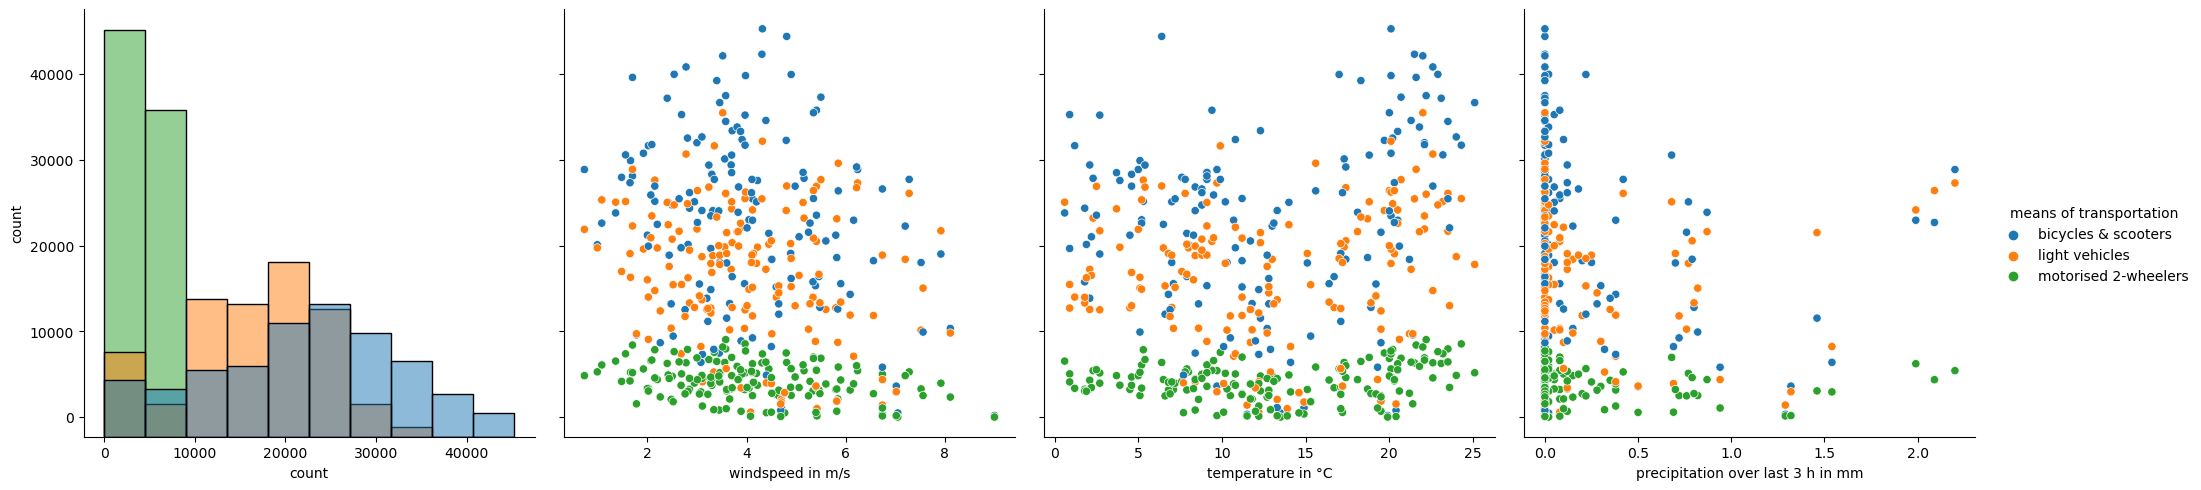

In [23]:
x_vars = ["count","windspeed in m/s", "temperature in °C", "precipitation over last 3 h in mm"]
y_vars = ["count"]
g = sns.PairGrid(joint_df, hue="means of transportation", x_vars=x_vars, y_vars=y_vars, height=5)
g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.savefig('transportation_gridplot')

Conclusion: there are no clusters. People who use a bike as means of transportation do so independet of meteorological conditions. The same is true for cars and 2-wheelers.


Data sets:

https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

https://opendata.paris.fr/explore/dataset/comptage-multimodal-comptages/information/?disjunctive.label&disjunctive.mode&disjunctive.voie&disjunctive.sens&disjunctive.trajectoire